In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = pathlib.Path("Grapevine_Leaves_Image_Dataset")
# Get a list of all items (files and directories) in the directory
all_items = os.listdir(data_dir)

# Filter out only the directories
folders = [item for item in all_items if os.path.isdir(os.path.join(data_dir, item))]

# Print the list of folders
print("Folders in the directory:")
for folder in folders:
    print(folder)

Folders in the directory:
Dimnit
Ak
Ala_Idris
Nazli
Buzgulu


In [3]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

500


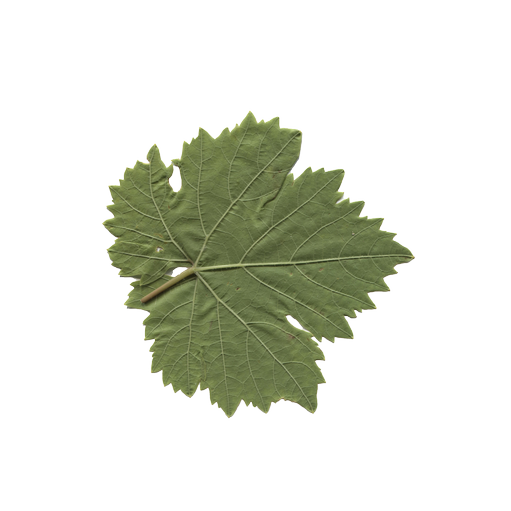

In [4]:
# View one leaf
ak_grape = list(data_dir.glob('Ak/*'))
PIL.Image.open(str(ak_grape[0]))

In [5]:
batch_size = 16
img_height = 299
img_width = 299

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 5 classes.
Using 400 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 5 classes.
Using 100 files for validation.


## Standardize the data

In [8]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

### Step 6 : Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.

In [9]:
# Load necessary libraries related to GoogleNet(InceptionNet)
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [10]:
# Assuming img_height and img_width are defined
input_shape_var = (img_height, img_width, 3)

In [11]:
# Load the weights of the pre-trained model Imagenet
# include_top=False, means that the final fully connected layer (top layer)
# of the original InceptionV3 model which is responsible for ImageNets 1000 class
# classification is not included, implying custom layers can be added
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape_var)

In [12]:
# Pre-trained InceptionV3 model is being used for transfer learning
# Loop iterrates thru all layers in InceptionV3 except for the last 15 layers fine tune
# This freezes the weights of the layers, preventing from being updated.
# Idea to retain the pre-trained knowledge.
for layer in InceptionV3_model.layers[:-15]:
    layer.trainable = False
# Add layers on top of pretrained model
x = InceptionV3_model.output
# layer performs global average pooling over spatial dimensions of iunput
# reduces each spatial dimension(h, w) by taking average values of dimension
# convert spatial info in feature map to compact representation 
x = layers.GlobalAveragePooling2D()(x)
# convert global average pooling layer to one dimension, converts 3D tensor
# to 1D tensorby concatenating values
x = layers.Flatten()(x)
# Fully connected layer with 512 units and relu activation,
# adds weighs and bias to model, and relu adds non-linearity
x = layers.Dense(units=512, activation='relu')(x)
# dropout helps with overfitting, by setting input units to 0
x = layers.Dropout(0.3)(x)
x = layers.Dense(units=512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
# output layer with 5 classes
output  = layers.Dense(units=5)(x)
model = Model(InceptionV3_model.input, output)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

 conv2d_11 (Conv2D)          (None, 35, 35, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 35, 35, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 35, 35, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 35, 35, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 35, 35, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 35, 35, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 35, 35, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 35, 35, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 35, 35, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 35, 35, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 17, 17, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 17, 17, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 17, 17, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 17, 17, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 17, 17, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 17, 17, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 17, 17, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 17, 17, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 17, 17, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 17, 17, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 17, 17, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 17, 17, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 17, 17, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 17, 17, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 17, 17, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 17, 17, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 17, 17, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 8, 8, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 8, 8, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 8, 8, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 8, 8, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 8, 8, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 8, 8, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 8, 8, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 8, 8, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 8, 8, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 8, 8, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [13]:
model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"])

In [14]:
history = model.fit(train_ds, steps_per_epoch=4, epochs=25, validation_data=val_ds, validation_steps=2)

Epoch 1/25
4/4 [==============================] - 4s 804ms/step - loss: 1.8241 - accuracy: 0.2344 - val_loss: 1.7633 - val_accuracy: 0.2500
Epoch 2/25
4/4 [==============================] - 2s 674ms/step - loss: 1.6416 - accuracy: 0.3281 - val_loss: 1.2324 - val_accuracy: 0.4688
Epoch 3/25
4/4 [==============================] - 2s 683ms/step - loss: 1.5261 - accuracy: 0.3594 - val_loss: 1.6144 - val_accuracy: 0.3438
Epoch 4/25
4/4 [==============================] - 3s 702ms/step - loss: 1.7029 - accuracy: 0.3906 - val_loss: 1.3164 - val_accuracy: 0.3438
Epoch 5/25
4/4 [==============================] - 2s 682ms/step - loss: 1.3912 - accuracy: 0.3906 - val_loss: 1.2650 - val_accuracy: 0.4688
Epoch 6/25
4/4 [==============================] - 3s 701ms/step - loss: 1.0893 - accuracy: 0.5469 - val_loss: 1.3505 - val_accuracy: 0.4688
Epoch 7/25
4/4 [==============================] - 1s 305ms/step - loss: 1.5064 - accuracy: 0.5000 - val_loss: 0.8939 - val_accuracy: 0.6562


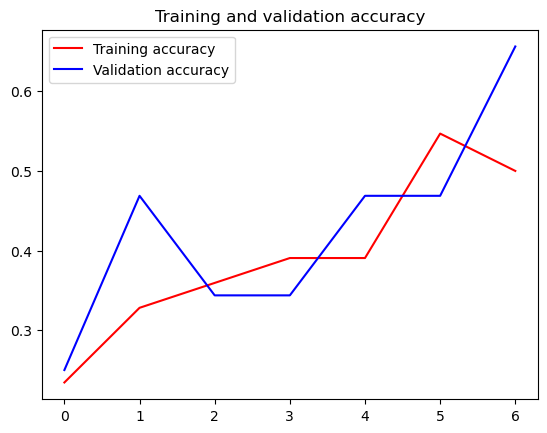

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [16]:
predictions = model.predict(val_ds)

7/7 [==============================] - 3s 351ms/step


In [17]:
test_loss, test_acc = model.evaluate(val_ds)
print('Test accuracy:', test_acc)

7/7 [==============================] - 3s 349ms/step - loss: 1.1367 - accuracy: 0.5500
Test accuracy: 0.550000011920929


### Load an existing model and weights